In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
sys.path.append("..") # 为了了导⼊入上层⽬目录的d2lzh_pytorch
# import d2lzh_pytorch as d2l

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

In [3]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [4]:
# 本函数已保存在d2lzh包中⽅方便便以后使⽤用
def use_svg_display():
    # ⽤用⽮矢量量图显示
    display.set_matplotlib_formats('svg')
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankleboot']
    return [text_labels[int(i)] for i in labels]
# 本函数已保存在d2lzh包中⽅方便便以后使⽤用
def show_fashion_mnist(images, labels):
    use_svg_display()
    # 这⾥里里的_表示我们忽略略（不不使⽤用）的变量量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

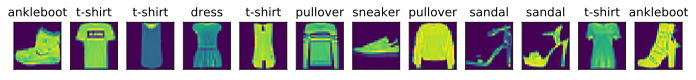

In [7]:
X, y = [], []
for i in range(12):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

In [8]:
# 读取⼩小批量量
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0 # 0表示不不⽤用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [14]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

3.81 sec


In [56]:
# 初始化模型参数
num_inputs = 784
num_outputs = 10
W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)
# 同之前⼀一样，我们需要模型参数梯度
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [29]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


In [57]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition # 这⾥里里应⽤用了了⼴广播机制
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.1455, 0.1241, 0.2430, 0.2773, 0.2101],
        [0.1388, 0.3018, 0.2293, 0.1903, 0.1398]]) tensor([1.0000, 1.0000])


In [58]:
# 定义模型
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)
# 定义损失函数
# y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# y = torch.LongTensor([0, 2])
# y_hat.gather(1, y.view(-1, 1))
# 交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

# 计算分类准确率
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()
# print(accuracy(y_hat, y))

# 本函数已保存在d2lzh_pytorch包中⽅方便便以后使⽤用。该函数将被逐步改进：它的完整实现将在“图像增⼴广”⼀一节中描述
# 类似地，我们可以评价模型 net 在数据集 data_iter 上的准确率
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n
# print(evaluate_accuracy(test_iter, net)) 

In [59]:
# 训练模型
num_epochs, lr = 5, 0.1
def sgd(params, lr, batch_size): # 本函数已保存在d2lzh_pytorch包中⽅方便便以后使⽤用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这⾥里里更更改param时⽤用的param.data
# 本函数已保存在d2lzh包中⽅方便便以后使⽤用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step() # “softmax回归的简洁实现”⼀一节将⽤用到
                
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [60]:
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7865, train acc 0.748, test acc 0.789
epoch 2, loss 0.5703, train acc 0.813, test acc 0.813
epoch 3, loss 0.5242, train acc 0.826, test acc 0.819
epoch 4, loss 0.5007, train acc 0.833, test acc 0.826
epoch 5, loss 0.4851, train acc 0.837, test acc 0.827


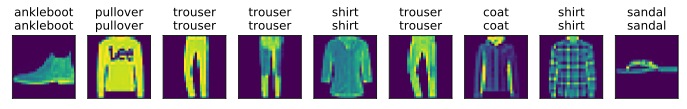

In [67]:
# 预测
X, y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).detach().numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])

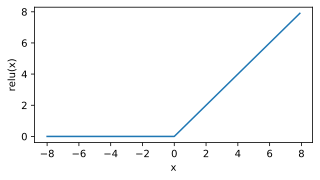

In [2]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.append("..")
import d2l
def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

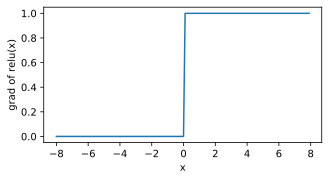

In [3]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

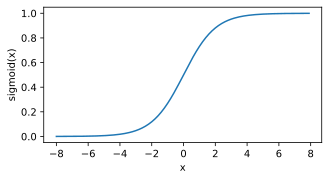

In [4]:
y = x.sigmoid()
xyplot(x, y, 'sigmoid')

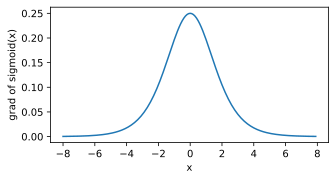

In [5]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of sigmoid')

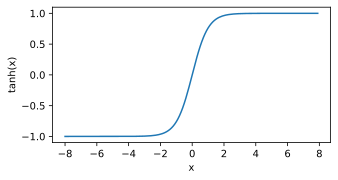

In [6]:
y = x.tanh()
xyplot(x, y, 'tanh')

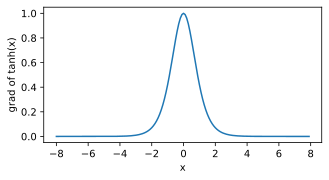

In [7]:
x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'grad of tanh')

In [1]:
# 多层感知机的从零开始实现
import torch
import numpy as np
import sys
sys.path.append("..")
import d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [3]:
# 定义模型参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)
params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)
    
# 定义激活函数
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

# 定义模型
def net(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

# 定义损失函数
loss = torch.nn.CrossEntropyLoss()

In [4]:
# 训练模型
num_epochs, lr = 5, 100.0
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0030, train acc 0.712, test acc 0.802
epoch 2, loss 0.0019, train acc 0.824, test acc 0.837
epoch 3, loss 0.0017, train acc 0.843, test acc 0.837
epoch 4, loss 0.0016, train acc 0.855, test acc 0.849
epoch 5, loss 0.0014, train acc 0.865, test acc 0.854
